In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import math
import zipfile
import json
import gzip
import shutil
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display

In [0]:
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
DATASET_PATH = "/content/drive/My Drive/MASTER/Sound Classification/genres"
JSON_PATH = "/content/drive/My Drive/MASTER/Sound Classification/genres.json"

In [0]:
def save_mfcc(dataset_path, json_path, n_mfcc = 13, n_fft = 2048, hop_length = 512, num_segments = 5):

  # dictionary to store data

  data = {
      "mapping" : [],
      "mfcc" : [],
      "labels" : []
  }

  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_per_segment = math.ceil(num_samples_per_segment / hop_length)

  # loop through all genres

  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    print("{}\n {}\n {}\n".format(dirpath, dirnames, filenames))

    if dirpath != dataset_path:


      dirpath_components = dirpath.split("/") # genre/blues => ("genre", "blues")
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)

      print("\nProcessing {}".format(semantic_label))

      # process file for a specific genre

      for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)

        signal, sr = librosa.load(file_path, sr = SAMPLE_RATE)

        # process segments extracting mfcc and storing data

        for s in range(num_segments):
          start_sample = num_samples_per_segment * s
          end_sample = start_sample + num_samples_per_segment



          mfcc = librosa.feature.mfcc(signal[start_sample:end_sample],
                                      sr = sr,
                                      n_fft = n_fft,
                                      n_mfcc = n_mfcc,
                                      hop_length = hop_length)
          mfcc = mfcc.T

          # store mfcc for segment if it has the expected length

          if len(mfcc) == expected_num_mfcc_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)

            print("{}, segment: {}".format(file_path, s))
    

  with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent = 4)




In [0]:
def load_data(json_path):

  with open(json_path, "r") as read_file:
      data = json.load(read_file)
      
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs, targets

# CNN classifier for music genre recognition

In [0]:
def prepare_datasets(test_size):

  X, y = load_data(JSON_PATH)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_test, y_train, y_test



In [0]:
x_train, x_test, y_train, y_test = prepare_datasets(0.2)

In [0]:
def model_cnn(input_shape, num_classes):

  model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = input_shape),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPool2D(),

          tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPool2D(),

          tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPool2D(),

          tf.keras.layers.Flatten(),

          tf.keras.layers.Dense(32, activation = 'relu'),
          tf.keras.layers.Dropout(rate = 0.35),
          tf.keras.layers.Dense(64, activation = 'relu'),
          tf.keras.layers.Dropout(rate = 0.35),


          tf.keras.layers.Dense(num_classes, activation = 'softmax')

  ])


  model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(0.00008),
                metrics = ['accuracy'])
  
  return model

In [0]:
model = model_cnn(x_train[0].shape, len(np.unique(y_train)))

In [0]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 259, 13, 16)       160       
_________________________________________________________________
batch_normalization_53 (Batc (None, 259, 13, 16)       64        
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 129, 6, 16)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 129, 6, 32)        4640      
_________________________________________________________________
batch_normalization_54 (Batc (None, 129, 6, 32)        128       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 64, 3, 32)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 3, 64)       

In [0]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32,
                    validation_split = 0.2)

Train on 3198 samples, validate on 800 samples
Epoch 1/100
3198/3198 [==============================] - 1s 359us/sample - loss: 2.3512 - accuracy: 0.1445 - val_loss: 2.2558 - val_accuracy: 0.1088
Epoch 2/100
3198/3198 [==============================] - 1s 170us/sample - loss: 2.1674 - accuracy: 0.2042 - val_loss: 2.1833 - val_accuracy: 0.2612
Epoch 3/100
3198/3198 [==============================] - 1s 174us/sample - loss: 2.1243 - accuracy: 0.2226 - val_loss: 2.0455 - val_accuracy: 0.3350
Epoch 4/100
3198/3198 [==============================] - 1s 163us/sample - loss: 2.0454 - accuracy: 0.2595 - val_loss: 1.9496 - val_accuracy: 0.3613
Epoch 5/100
3198/3198 [==============================] - 1s 169us/sample - loss: 1.9908 - accuracy: 0.2799 - val_loss: 1.8597 - val_accuracy: 0.3750
Epoch 6/100
3198/3198 [==============================] - 1s 164us/sample - loss: 1.9557 - accuracy: 0.2971 - val_loss: 1.7970 - val_accuracy: 0.3938
Epoch 7/100
3198/3198 [==============================] - 1s

In [0]:
loss, accuracy = model.evaluate(x_test, y_test)

1000/1000 [==============================] - 0s 204us/sample - loss: 1.0529 - accuracy: 0.7140


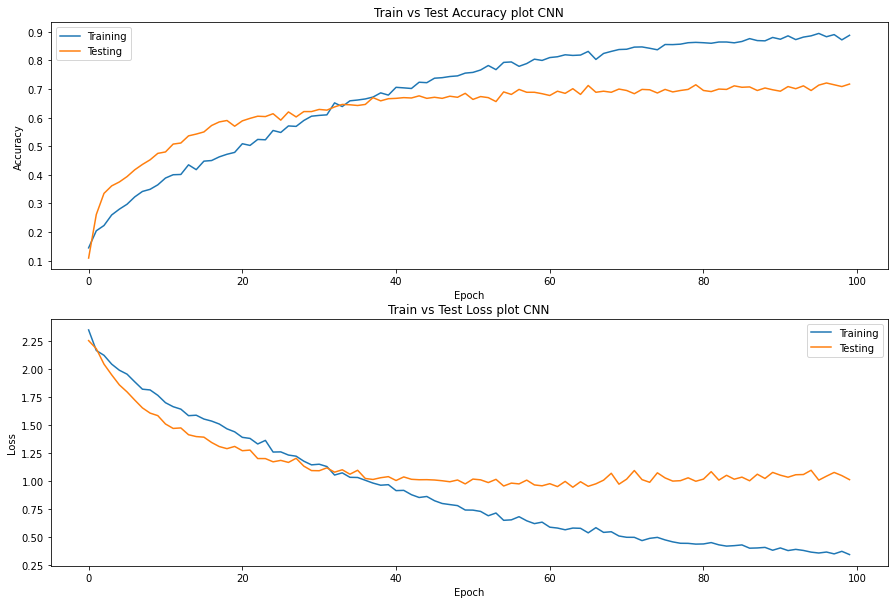

In [0]:
fig, axs = plt.subplots(2)



axs[0].plot(history.history["accuracy"], label = "Training")
axs[0].plot(history.history["val_accuracy"], label = "Testing")

axs[0].set_title('Train vs Test Accuracy plot CNN')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc = 'best')

plt.rcParams['figure.figsize'] = [15, 10]
#plt.axis([0, 100, 0, 1]) 

axs[1].set_title('Train vs Test Loss plot CNN')

axs[1].plot(history.history["loss"], label = "Training")
axs[1].plot(history.history["val_loss"], label = "Testing")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(loc = 'best')

plt.show()

# RNN classifier for music genre recognition

In [0]:
def model_rnn(input_shape, num_classes):

  model = tf.keras.Sequential([
      tf.keras.layers.LSTM(64, input_shape = input_shape, return_sequences=True),
      tf.keras.layers.LSTM(64),

      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),

      tf.keras.layers.Dense(num_classes, activation='softmax')

  ])


  model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(0.0001),
                metrics = ['accuracy'])
  
  return model

In [0]:
model = model_rnn(x_train[0].shape, len(np.unique(y_train)))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 259, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32,
                    validation_split = 0.2)

Epoch 1/100
100/100 [==============================] - 3s 33ms/step - loss: 2.2659 - accuracy: 0.1470 - val_loss: 2.1959 - val_accuracy: 0.2087
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 2.1439 - accuracy: 0.2464 - val_loss: 2.0478 - val_accuracy: 0.3162
Epoch 3/100
100/100 [==============================] - 3s 26ms/step - loss: 1.9790 - accuracy: 0.3233 - val_loss: 1.8932 - val_accuracy: 0.3587
Epoch 4/100
100/100 [==============================] - 3s 26ms/step - loss: 1.8233 - accuracy: 0.3702 - val_loss: 1.7693 - val_accuracy: 0.3887
Epoch 5/100
100/100 [==============================] - 3s 26ms/step - loss: 1.7205 - accuracy: 0.4128 - val_loss: 1.6761 - val_accuracy: 0.4150
Epoch 6/100
100/100 [==============================] - 3s 26ms/step - loss: 1.6305 - accuracy: 0.4384 - val_loss: 1.6080 - val_accuracy: 0.4363
Epoch 7/100
100/100 [==============================] - 3s 26ms/step - loss: 1.5797 - accuracy: 0.4597 - val_loss: 1.5641 - val_accuracy:

In [0]:
loss_rnn, accuracy_rnn = model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 13ms/step - loss: 1.2712 - accuracy: 0.6050


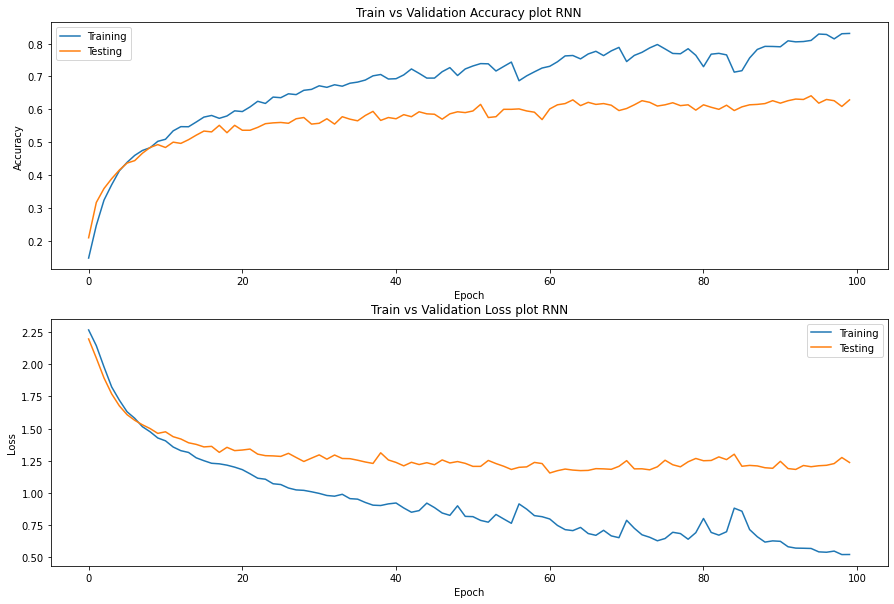

In [0]:
fig, axs = plt.subplots(2)



axs[0].plot(history.history["accuracy"], label = "Training")
axs[0].plot(history.history["val_accuracy"], label = "Testing")

axs[0].set_title('Train vs Validation Accuracy plot RNN')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc = 'best')

plt.rcParams['figure.figsize'] = [15, 10]
#plt.axis([0, 100, 0, 1]) 

axs[1].set_title('Train vs Validation Loss plot RNN')

axs[1].plot(history.history["loss"], label = "Training")
axs[1].plot(history.history["val_loss"], label = "Testing")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(loc = 'best')

plt.show()